# Experiments

This notebook has the code for running several experiments on our LSH Forest approach to approximating Chamfer similarity

In [ ]:

import numpy as np
from tqdm import tqdm

from shared.lsh_forest import RandomHyperplaneLSH
from shared.recursive_lsh_forest import RecursiveLSHForest
from shared.retrieval import rank_documents, sim_scores, collect_matches
from shared.utils import recall, chamfer, timed, build_rec_forest
from shared.plotting import plot, plot_with_trendline, plot_with_identity_line


# Constants
n = 1000                                # number of documents
q = 15                                  # vectors per query
m = 100                                # vectors per document
d = 128                                 # dimension per vector
l = 10                                  # trees per forest
k = 10                                  # pivots to keep per node in tree
km = 15                                 # max depth of each tree
a = 10                                  # number of neighbors to retrieve per query
max_split_ratio = 1.2
max_hash_attempts = 1

distance = lambda a, b: -np.dot(a, b)
defaults = dict(l=l, km=km, a=a)

rng = np.random.default_rng(42)

# Generate our simulated random data
data = rng.normal(size=(n, m, d)).astype(np.float32)
data /= np.linalg.norm(data, axis=-1, keepdims=True)

queries = rng.normal(size=(q, d)).astype(np.float32)
queries /= np.linalg.norm(queries, axis=-1, keepdims=True)

experiments = {
        'l':  list(range(1, 21)),
        'a':  list(range(1, 101))
}




# Test that our forest retrieves the nearest neighbor
Plot recall vs num trees and candidates

72 0.3601049780845642
[  72 1812 7880 7640 2782 4119 7946 9164 7231  962]


100%|██████████| 40/40 [09:02<00:00, 13.57s/it]


Finished recall experiment: l


100%|██████████| 40/40 [00:56<00:00,  1.40s/it]


Finished recall experiment: km


100%|██████████| 200/200 [00:00<00:00, 871.65it/s]

Finished recall experiment: a


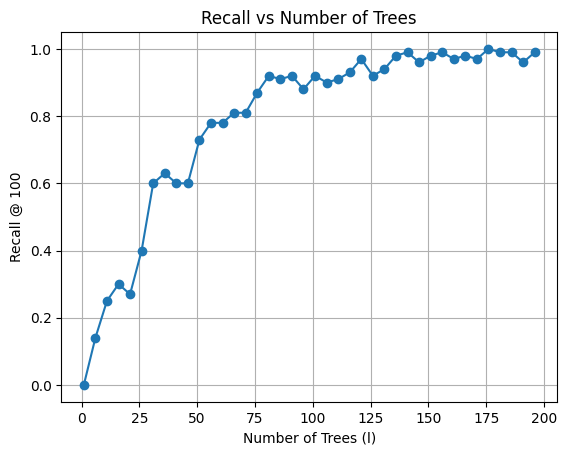

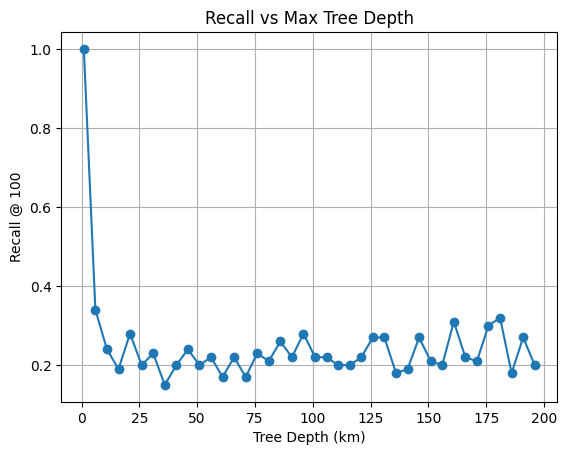

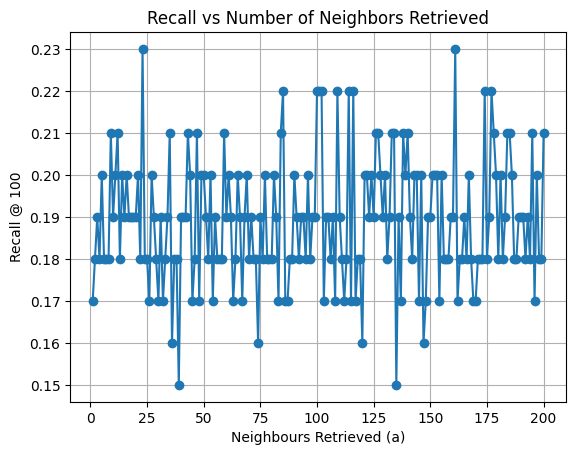

In [ ]:

# Baseline for the first
sims = data[0] @ queries[0]
best_doc = int(np.argmax(sims))
best_score = float(sims[best_doc])
print(best_doc, best_score)

true_ranking = np.argsort(-sims)
print(true_ranking[:10])

def recall_experiment(variable, values, defaults, num_items):
        # Build tree once
        tree_params = {'km', 'max_split_ratio', 'max_hash_attempts', 'l'}
        if variable not in tree_params:
                forests = build_rec_forest(data, defaults['l'], defaults['km'], d, max_hash_attempts=1)

        recall_vals = []
        for value in tqdm(values):
                parameters = defaults.copy()
                parameters[variable] = value
                
                # Rebuild if necessary
                if variable in tree_params:
                        forests = build_rec_forest(data, parameters['l'], parameters['km'], d, max_hash_attempts=1)

                a = parameters['a']
                forest = forests[0]
                indices = forest.query(queries[0], num_items, distance, k=num_items,)
                recall_vals.append(recall(true_ranking[:num_items], indices, num_items))
        print(f"Finished recall experiment: {variable}")
        return recall_vals


recall_k = 100
results = {var: recall_experiment(var, vals, defaults, recall_k) for var, vals in experiments.items()}
plot(experiments['l'],  results['l'],  'Number of Trees (l)', f"Recall @ {recall_k}", "Recall vs Number of Trees")
plot(experiments['a'],  results['a'],  'Neighbours Retrieved (a)', f"Recall @ {recall_k}", "Recall vs Number of Neighbors Retrieved")



# Test that our forest approach approximates chamfer
Plot Chamfer distance vs Our distance for all of the documents in our data set

In [2]:
# Baseline
sims = np.array([chamfer(queries, doc_vecs) for doc_vecs in data], dtype=np.float32)
best_doc = int(np.argmax(sims))
best_score = float(sims[best_doc])
print(best_doc, best_score)

true_ranking = np.argsort(-sims)
print(true_ranking[:10])

659 3.866861581802368
[659 706 371 664 822 226 577 704 842 588]


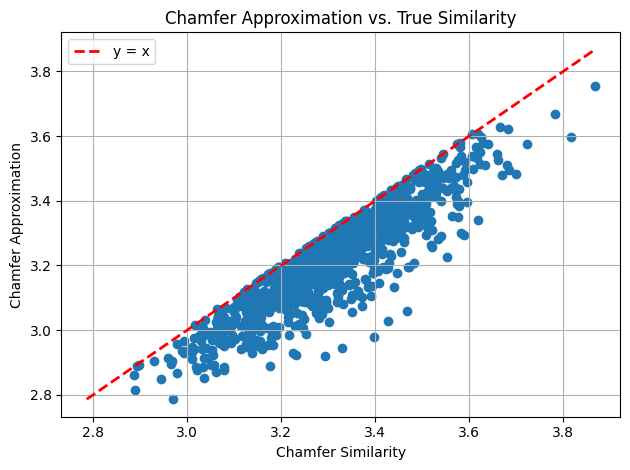

In [3]:

forests = build_rec_forest(data, l, km, d, max_hash_attempts=1)
scores = sim_scores(collect_matches(forests, queries, distance, a), queries)
plot_with_identity_line(sims, scores, "Chamfer Similarity", "Chamfer Approximation", "Chamfer Approximation vs. True Similarity")

# Test recall on our simulated data set
Plot recall vs num trees, candidates, max depth, pivots

  1%|          | 1/100 [00:00<01:13,  1.34it/s]

rank_documents took 0.7434 sec


  2%|▏         | 2/100 [00:01<01:20,  1.21it/s]

rank_documents took 0.8783 sec


  3%|▎         | 3/100 [00:02<01:28,  1.10it/s]

rank_documents took 1.0105 sec


  4%|▍         | 4/100 [00:03<01:37,  1.02s/it]

rank_documents took 1.1837 sec


  5%|▌         | 5/100 [00:05<01:46,  1.12s/it]

rank_documents took 1.2926 sec


  6%|▌         | 6/100 [00:06<01:54,  1.22s/it]

rank_documents took 1.4064 sec


  7%|▋         | 7/100 [00:08<02:02,  1.31s/it]

rank_documents took 1.5144 sec


  8%|▊         | 8/100 [00:09<02:09,  1.41s/it]

rank_documents took 1.6038 sec


  9%|▉         | 9/100 [00:11<02:16,  1.50s/it]

rank_documents took 1.6981 sec


 10%|█         | 10/100 [00:13<02:24,  1.60s/it]

rank_documents took 1.8432 sec


 11%|█         | 11/100 [00:15<02:31,  1.70s/it]

rank_documents took 1.9079 sec


 12%|█▏        | 12/100 [00:17<02:36,  1.78s/it]

rank_documents took 1.9740 sec


 13%|█▎        | 13/100 [00:19<02:42,  1.87s/it]

rank_documents took 2.0672 sec


 14%|█▍        | 14/100 [00:21<02:48,  1.95s/it]

rank_documents took 2.1516 sec


 15%|█▌        | 15/100 [00:23<02:53,  2.04s/it]

rank_documents took 2.2270 sec


 16%|█▌        | 16/100 [00:25<02:58,  2.12s/it]

rank_documents took 2.3183 sec


 17%|█▋        | 17/100 [00:28<03:03,  2.21s/it]

rank_documents took 2.4132 sec


 18%|█▊        | 18/100 [00:30<03:06,  2.27s/it]

rank_documents took 2.4079 sec


 19%|█▉        | 19/100 [00:33<03:08,  2.33s/it]

rank_documents took 2.4815 sec


 20%|██        | 20/100 [00:35<03:11,  2.39s/it]

rank_documents took 2.5317 sec


 21%|██        | 21/100 [00:38<03:13,  2.45s/it]

rank_documents took 2.5909 sec


 22%|██▏       | 22/100 [00:40<03:15,  2.51s/it]

rank_documents took 2.6361 sec


 23%|██▎       | 23/100 [00:43<03:18,  2.58s/it]

rank_documents took 2.7428 sec


 24%|██▍       | 24/100 [00:46<03:19,  2.62s/it]

rank_documents took 2.7315 sec


 25%|██▌       | 25/100 [00:49<03:20,  2.67s/it]

rank_documents took 2.7748 sec


 26%|██▌       | 26/100 [00:51<03:21,  2.72s/it]

rank_documents took 2.8297 sec


 27%|██▋       | 27/100 [00:54<03:22,  2.78s/it]

rank_documents took 2.9212 sec


 28%|██▊       | 28/100 [00:57<03:23,  2.82s/it]

rank_documents took 2.9213 sec


 29%|██▉       | 29/100 [01:00<03:24,  2.88s/it]

rank_documents took 3.0056 sec


 30%|███       | 30/100 [01:03<03:23,  2.91s/it]

rank_documents took 2.9942 sec


 31%|███       | 31/100 [01:06<03:23,  2.95s/it]

rank_documents took 3.0408 sec


 32%|███▏      | 32/100 [01:09<03:23,  2.99s/it]

rank_documents took 3.0728 sec


 33%|███▎      | 33/100 [01:13<03:22,  3.03s/it]

rank_documents took 3.1151 sec


 34%|███▍      | 34/100 [01:16<03:21,  3.06s/it]

rank_documents took 3.1387 sec


 35%|███▌      | 35/100 [01:19<03:22,  3.11s/it]

rank_documents took 3.2258 sec


 36%|███▌      | 36/100 [01:22<03:21,  3.14s/it]

rank_documents took 3.2120 sec


 37%|███▋      | 37/100 [01:25<03:20,  3.18s/it]

rank_documents took 3.2601 sec


 38%|███▊      | 38/100 [01:29<03:19,  3.22s/it]

rank_documents took 3.3177 sec


 39%|███▉      | 39/100 [01:32<03:17,  3.24s/it]

rank_documents took 3.2998 sec


 40%|████      | 40/100 [01:35<03:16,  3.27s/it]

rank_documents took 3.3212 sec


 41%|████      | 41/100 [01:39<03:16,  3.32s/it]

rank_documents took 3.4521 sec


 42%|████▏     | 42/100 [01:42<03:13,  3.34s/it]

rank_documents took 3.3633 sec


 43%|████▎     | 43/100 [01:46<03:10,  3.35s/it]

rank_documents took 3.3712 sec


 44%|████▍     | 44/100 [01:49<03:08,  3.37s/it]

rank_documents took 3.4135 sec


 45%|████▌     | 45/100 [01:52<03:06,  3.39s/it]

rank_documents took 3.4480 sec


 46%|████▌     | 46/100 [01:56<03:04,  3.42s/it]

rank_documents took 3.4933 sec


 47%|████▋     | 47/100 [01:59<03:02,  3.44s/it]

rank_documents took 3.5014 sec


 48%|████▊     | 48/100 [02:03<02:59,  3.46s/it]

rank_documents took 3.4897 sec


 49%|████▉     | 49/100 [02:06<02:57,  3.47s/it]

rank_documents took 3.5076 sec


 50%|█████     | 50/100 [02:10<02:54,  3.49s/it]

rank_documents took 3.5503 sec


 51%|█████     | 51/100 [02:14<02:54,  3.55s/it]

rank_documents took 3.6909 sec


 52%|█████▏    | 52/100 [02:17<02:52,  3.60s/it]

rank_documents took 3.6978 sec


 53%|█████▎    | 53/100 [02:21<02:49,  3.61s/it]

rank_documents took 3.6355 sec


 54%|█████▍    | 54/100 [02:25<02:48,  3.65s/it]

rank_documents took 3.7615 sec


 55%|█████▌    | 55/100 [02:28<02:44,  3.66s/it]

rank_documents took 3.6842 sec


 56%|█████▌    | 56/100 [02:32<02:41,  3.67s/it]

rank_documents took 3.6990 sec


 57%|█████▋    | 57/100 [02:36<02:40,  3.73s/it]

rank_documents took 3.8551 sec


 58%|█████▊    | 58/100 [02:40<02:37,  3.76s/it]

rank_documents took 3.8186 sec


 59%|█████▉    | 59/100 [02:44<02:34,  3.77s/it]

rank_documents took 3.8189 sec


 60%|██████    | 60/100 [02:47<02:31,  3.79s/it]

rank_documents took 3.8229 sec


 61%|██████    | 61/100 [02:51<02:28,  3.81s/it]

rank_documents took 3.8683 sec


 62%|██████▏   | 62/100 [02:55<02:27,  3.87s/it]

rank_documents took 4.0014 sec


 63%|██████▎   | 63/100 [02:59<02:23,  3.88s/it]

rank_documents took 3.8922 sec


 64%|██████▍   | 64/100 [03:03<02:20,  3.90s/it]

rank_documents took 3.9580 sec


 65%|██████▌   | 65/100 [03:07<02:16,  3.91s/it]

rank_documents took 3.9411 sec


 66%|██████▌   | 66/100 [03:11<02:13,  3.94s/it]

rank_documents took 3.9987 sec


 67%|██████▋   | 67/100 [03:15<02:10,  3.96s/it]

rank_documents took 4.0131 sec


 68%|██████▊   | 68/100 [03:19<02:08,  4.00s/it]

rank_documents took 4.0911 sec


 69%|██████▉   | 69/100 [03:23<02:04,  4.03s/it]

rank_documents took 4.0858 sec


 70%|███████   | 70/100 [03:27<02:01,  4.05s/it]

rank_documents took 4.1035 sec


 71%|███████   | 71/100 [03:32<01:58,  4.09s/it]

rank_documents took 4.1917 sec


 72%|███████▏  | 72/100 [03:36<01:55,  4.13s/it]

rank_documents took 4.2325 sec


 73%|███████▎  | 73/100 [03:40<01:51,  4.13s/it]

rank_documents took 4.1177 sec


 74%|███████▍  | 74/100 [03:44<01:47,  4.15s/it]

rank_documents took 4.1834 sec


 75%|███████▌  | 75/100 [03:48<01:43,  4.14s/it]

rank_documents took 4.1234 sec


 76%|███████▌  | 76/100 [03:52<01:39,  4.16s/it]

rank_documents took 4.1971 sec


 77%|███████▋  | 77/100 [03:57<01:36,  4.20s/it]

rank_documents took 4.3024 sec


 78%|███████▊  | 78/100 [04:01<01:32,  4.23s/it]

rank_documents took 4.2864 sec


 79%|███████▉  | 79/100 [04:05<01:29,  4.25s/it]

rank_documents took 4.3079 sec


 80%|████████  | 80/100 [04:10<01:25,  4.27s/it]

rank_documents took 4.3242 sec


 81%|████████  | 81/100 [04:14<01:22,  4.32s/it]

rank_documents took 4.4317 sec


 82%|████████▏ | 82/100 [04:19<01:19,  4.39s/it]

rank_documents took 4.5576 sec


 83%|████████▎ | 83/100 [04:23<01:14,  4.40s/it]

rank_documents took 4.4038 sec


 84%|████████▍ | 84/100 [04:27<01:10,  4.41s/it]

rank_documents took 4.4496 sec


 85%|████████▌ | 85/100 [04:32<01:06,  4.44s/it]

rank_documents took 4.4884 sec


 86%|████████▌ | 86/100 [04:36<01:02,  4.44s/it]

rank_documents took 4.4665 sec


 87%|████████▋ | 87/100 [04:41<00:57,  4.46s/it]

rank_documents took 4.4874 sec


 88%|████████▊ | 88/100 [04:45<00:53,  4.47s/it]

rank_documents took 4.4961 sec


 89%|████████▉ | 89/100 [04:50<00:49,  4.50s/it]

rank_documents took 4.5774 sec


 90%|█████████ | 90/100 [04:55<00:45,  4.52s/it]

rank_documents took 4.5448 sec


 91%|█████████ | 91/100 [04:59<00:40,  4.55s/it]

rank_documents took 4.6454 sec


 92%|█████████▏| 92/100 [05:04<00:36,  4.56s/it]

rank_documents took 4.5884 sec


 93%|█████████▎| 93/100 [05:08<00:32,  4.60s/it]

rank_documents took 4.6905 sec


 94%|█████████▍| 94/100 [05:13<00:27,  4.62s/it]

rank_documents took 4.6590 sec


 95%|█████████▌| 95/100 [05:18<00:23,  4.63s/it]

rank_documents took 4.6524 sec


 96%|█████████▌| 96/100 [05:22<00:18,  4.64s/it]

rank_documents took 4.6625 sec


 97%|█████████▋| 97/100 [05:27<00:13,  4.66s/it]

rank_documents took 4.7059 sec


 98%|█████████▊| 98/100 [05:32<00:09,  4.69s/it]

rank_documents took 4.7534 sec


 99%|█████████▉| 99/100 [05:37<00:04,  4.71s/it]

rank_documents took 4.7709 sec


100%|██████████| 100/100 [05:40<00:00,  3.41s/it]

rank_documents took 3.5288 sec
Finished recall experiment: a


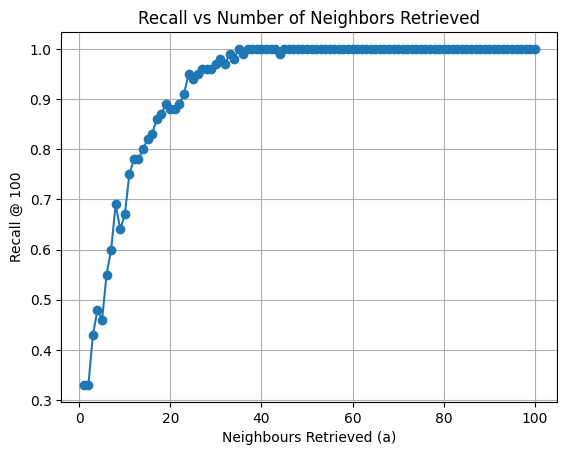

In [ ]:
def recall_experiment(variable, values, defaults, num_items):
        # Build tree once
        tree_params = {'km', 'max_split_ratio', 'max_hash_attempts', 'l'}
        if variable not in tree_params:
                forests = build_rec_forest(data, defaults['l'], defaults['km'], d, max_hash_attempts=1)

        recall_vals = []
        for value in tqdm(values):
                parameters = defaults.copy()
                parameters[variable] = value
                
                # Rebuild if necessary
                if variable in tree_params:
                        forests = build_rec_forest(data, parameters['l'], parameters['km'], d, max_hash_attempts=1)

                ranking = timed(rank_documents, forests, queries, distance, parameters['a'])
                recall_vals.append(recall(true_ranking, ranking, num_items))
        print(f"Finished recall experiment: {variable}")
        return recall_vals
        
recall_k = 100
results = {var: recall_experiment(var, vals, defaults, recall_k) for var, vals in experiments.items()}
plot(experiments['l'],  results['l'],  'Number of Trees (l)', f"Recall @ {recall_k}", "Recall vs Number of Trees")
plot(experiments['a'],  results['a'],  'Neighbours Retrieved (a)', f"Recall @ {recall_k}", "Recall vs Number of Neighbors Retrieved")
